In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [2]:
state = 'CA'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_cumulative = df[df['Entity']=='California']['people_vaccinated'].to_numpy().reshape(-1, 1)

In [5]:
print("Currently Vaccinated Untill today in {} is {}".format(state,vaccines_cumulative[-1]))

Currently Vaccinated Untill today in CA is [20047379]


States to be worked on are:
- California: 39,512,223
- New York: 19,453,561
- Virginia: 8,535,519

# Preprocessing Data

In [6]:
scaler = MinMaxScaler(feature_range=(-1,+1.0))
vaccines_daily = cumulative_to_daily(vaccines_cumulative)
vaccines_daily_normalized = scaler.fit_transform(vaccines_daily.reshape(-1, 1))

In [7]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [8]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_daily_normalized,window_size)

X_all, y_all = torch.FloatTensor(X).to(device), torch.FloatTensor(Y).to(device) # Full data to be trained on

# Load into DataLoader
all_loader = DataLoader(TensorDataset(X_all, y_all),batch_size=32, shuffle=True)

# y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [9]:
import gc
gc.collect()

4

In [10]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=128, n_heads=8, n_hidden=128, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(all_loader,criterion,optimizer,n_epochs = 100 )

Epoch 1 Loss is 0.18642141421635947
Epoch 2 Loss is 0.1379679118593534
Epoch 3 Loss is 0.0930967852473259
Epoch 4 Loss is 0.06597346067428589
Epoch 5 Loss is 0.06749709447224934
Epoch 6 Loss is 0.0717356950044632
Epoch 7 Loss is 0.06372939546902974
Epoch 8 Loss is 0.0630235696832339
Epoch 9 Loss is 0.06501871968309085
Epoch 10 Loss is 0.06539879739284515
Epoch 11 Loss is 0.06106493001182874
Epoch 12 Loss is 0.06275788322091103
Epoch 13 Loss is 0.06349862366914749
Epoch 14 Loss is 0.06577086076140404
Epoch 15 Loss is 0.059591061125199
Epoch 16 Loss is 0.06229226663708687
Epoch 17 Loss is 0.06286626309156418
Epoch 18 Loss is 0.06274315218130748
Epoch 19 Loss is 0.06386043752233188
Epoch 20 Loss is 0.06767514099677403
Epoch 21 Loss is 0.06428841253121693
Epoch 22 Loss is 0.060696329921483994
Epoch 23 Loss is 0.06456919386982918
Epoch 24 Loss is 0.0599017987648646
Epoch 25 Loss is 0.0645558734734853
Epoch 26 Loss is 0.05573353357613087
Epoch 27 Loss is 0.06296082337697347
Epoch 28 Loss is 

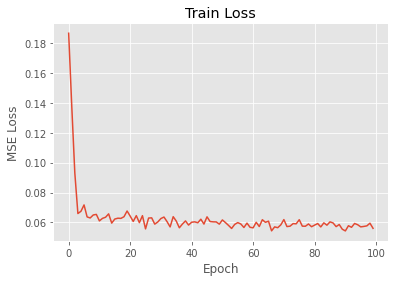

In [11]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [12]:
torch.FloatTensor(X).to(device).shape

torch.Size([82, 30, 1])

In [13]:
import gc
gc.collect()

0

In [21]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint,None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
    print(datapoint.shape)
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    return forecasted

forecasted_days_normalized = forecast_TST(TST_model,X=X_all[-1],forecast_len=95,n_seed = window_size )

torch.Size([125, 1, 1])


In [22]:
forecasted_days_normalized.shape

torch.Size([95])

In [24]:
daily_forecasted__nonNormalized = scaler.inverse_transform(forecasted_days_normalized.cpu().detach().numpy().reshape(-1, 1))
# plt.plot(forecasted_days_normalized.cpu().detach().numpy())
cumulative_forecasted = daily_to_cumulative(daily_forecasted__nonNormalized)

In [25]:
vaccines_cumulative[-1] + cumulative_forecasted[-1]

array([39372807.])

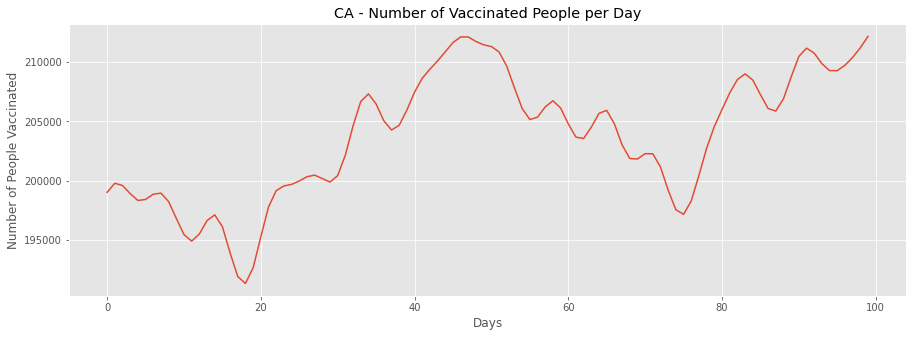

In [20]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(daily_forecasted__nonNormalized)

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} - Number of Vaccinated People per Day'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Number of People Vaccinated')
# leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()